<a href="https://colab.research.google.com/github/kridtapon/WFO-New-Demand-Driven-KST-Strategy/blob/main/WFO_New_Demand_Driven_KST_Strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.6/527.6 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 48.3 MB/s eta 0:00:00


[*********************100%***********************]  1 of 1 completed
<ipython-input-4-7f95483097ac>:56: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-4-7f95483097ac>:57: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-4-7f95483097ac>:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in


Walk-Forward Optimization Results:
   Year           Best_Params  Test_Return
0  2020  (11, 17, 13, 18, 13)     0.641199
1  2021    (11, 27, 9, 18, 9)     0.294098
2  2022    (19, 25, 7, 16, 9)     0.397844
3  2023    (17, 25, 5, 16, 9)     0.145767
4  2024    (19, 19, 5, 10, 9)     0.569627
5  2025     (9, 17, 5, 18, 7)     0.000000
Start                         2020-01-02 00:00:00
End                           2024-12-31 00:00:00
Period                                       1258
Start Value                              100000.0
End Value                            622119.55143
Total Return [%]                       522.119551
Benchmark Return [%]                   370.656037
Max Gross Exposure [%]                      100.0
Total Fees Paid                      13252.252858
Max Drawdown [%]                        34.715847
Max Drawdown Duration                       414.0
Total Trades                                   21
Total Closed Trades                            21
Total Open Tr

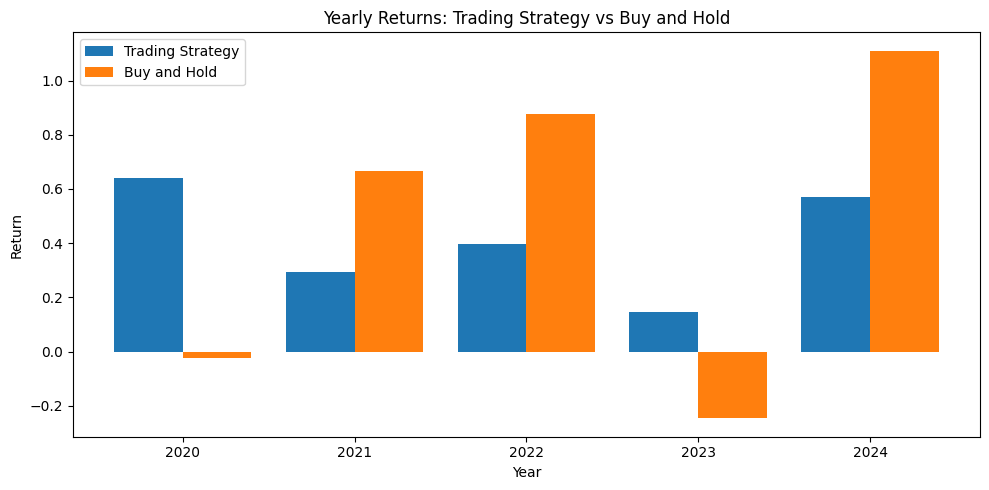


Annual Strategy vs Buy and Hold Returns:
   Year  Strategy_Return  Buy_and_Hold_Return
0  2020         0.641199            -0.024338
1  2021         0.294098             0.664809
2  2022         0.397844             0.874978
3  2023         0.145767            -0.246292
4  2024         0.569627             1.109992


In [4]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt
import matplotlib.pyplot as plt
import itertools

# Function to calculate the KST (Know Sure Thing) and Signal line
def calculate_kst(df, short_period=10, long_period=15, roc_short_period=5, roc_long_period=10):
    """
    Calculate KST (Know Sure Thing) and its Signal line.
    """
    # Rate of Change (ROC) for short and long periods
    roc_short = df['Close'].pct_change(periods=short_period) * 100
    roc_long = df['Close'].pct_change(periods=long_period) * 100
    roc_mid = df['Close'].pct_change(periods=roc_short_period) * 100
    roc_longer = df['Close'].pct_change(periods=roc_long_period) * 100

    # Smoothed ROC using weighted moving averages
    wma_short = roc_short.rolling(window=short_period).mean()
    wma_long = roc_long.rolling(window=long_period).mean()
    wma_mid = roc_mid.rolling(window=roc_short_period).mean()
    wma_longer = roc_longer.rolling(window=roc_long_period).mean()

    # KST = weighted sum of ROCs
    kst = (wma_short * 1) + (wma_long * 2) + (wma_mid * 3) + (wma_longer * 4)

    # Signal line: EMA of KST
    kst_signal = kst.ewm(span=9).mean()

    return kst, kst_signal

# Function to calculate the Demarker Indicator
def calculate_demarker(df, period=14):
    """
    Calculate the Demarker Indicator.
    """
    # Calculate the DeMarker Indicator
    dm_plus = np.maximum(df['High'].shift(1) - df['High'], 0)
    dm_minus = np.maximum(df['Low'] - df['Low'].shift(1), 0)

    # Calculate the smoothed values
    dem_plus = dm_plus.rolling(window=period).sum()
    dem_minus = dm_minus.rolling(window=period).sum()

    # Demarker Indicator
    dem = dem_plus / (dem_plus + dem_minus)

    return dem

# Function to calculate KST and Demarker indicators for a specific time period
def calculate_kst_demarker(df, kst_params, dem_period):
    kst, kst_signal = calculate_kst(df, *kst_params)
    dem = calculate_demarker(df, dem_period)

    df['KST'] = kst
    df['KST_Signal'] = kst_signal
    df['Demarker'] = dem

    return df

# Walk-forward optimization with KST and Demarker Indicator
def walk_forward_optimization_kst_demarker(df, start_year, end_year):
    results = []

    # Define dynamic ranges for KST and Demarker periods
    kst_short_period_range = range(7, 21, 2)  # Range for short periods
    kst_long_period_range = range(15, 31, 2)  # Range for long periods
    kst_roc_short_period_range = range(5, 15, 2)  # Range for ROC short periods
    kst_roc_long_period_range = range(10, 20, 2)  # Range for ROC long periods
    dem_period_range = range(7, 21, 2)  # Range for Demarker periods

    for test_year in range(start_year + 4, end_year + 1):
        train_start = test_year - 4
        train_end = test_year - 1
        test_start = test_year

        train_data = df[(df.index.year >= train_start) & (df.index.year <= train_end)]
        test_data = df[df.index.year == test_year]

        best_params = None
        best_performance = -np.inf

        # Loop through all combinations of KST and Demarker parameters
        for params in itertools.product(kst_short_period_range, kst_long_period_range,
                                        kst_roc_short_period_range, kst_roc_long_period_range, dem_period_range):
            short_period, long_period, roc_short_period, roc_long_period, dem_period = params

            # Calculate KST and Demarker indicators on the training data
            train_data = calculate_kst_demarker(train_data, (short_period, long_period, roc_short_period, roc_long_period), dem_period)

            # Generate entry and exit signals based on KST and Demarker
            entries = (train_data['KST'] > train_data['KST_Signal']) & (train_data['Demarker'] < 0.3)
            exits = (train_data['KST'] < train_data['KST_Signal']) & (train_data['Demarker'] > 0.7)

            # Backtest on training data
            portfolio = vbt.Portfolio.from_signals(
                close=train_data['Close'],
                entries=entries,
                exits=exits,
                init_cash=100_000,
                fees=0.001
            )

            performance = portfolio.total_return()
            if performance > best_performance:
                best_performance = performance
                best_params = (short_period, long_period, roc_short_period, roc_long_period, dem_period)

        # Test with the best parameters on the test data
        yearly_data = df[(df.index.year >= test_year - 1) & (df.index.year <= test_year)]

        # Apply KST and Demarker indicators
        yearly_data = calculate_kst_demarker(yearly_data, best_params[:4], best_params[4])

        # Keep only the second year to avoid missing values from indicator calculation
        yearly_data = yearly_data[yearly_data.index.year == test_year]

        entries = (yearly_data['KST'] > yearly_data['KST_Signal']) & (yearly_data['Demarker'] < 0.3)
        exits = (yearly_data['KST'] < yearly_data['KST_Signal']) & (yearly_data['Demarker'] > 0.7)

        portfolio = vbt.Portfolio.from_signals(
            close=yearly_data['Close'],
            entries=entries,
            exits=exits,
            init_cash=100_000,
            fees=0.001
        )

        results.append({
            'Year': test_year,
            'Best_Params': best_params,
            'Test_Return': portfolio.total_return()
        })

    return pd.DataFrame(results)

# Define the stock symbol and time period
symbol = 'TPL' # NRG TPL! TRGP! UAL
start_date = '2015-01-01'
end_date = '2025-01-01'

# Download the stock data
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']
df.ffill(inplace=True)

# Perform walk-forward optimization
results = walk_forward_optimization_kst_demarker(df, 2016, 2025)

# Display results
print("\nWalk-Forward Optimization Results:")
print(results)

# Combine signals into a single portfolio
combined_entries = pd.Series(False, index=df.index)
combined_exits = pd.Series(False, index=df.index)

for _, row in results.iterrows():
    year = row['Year']
    params = row['Best_Params']

    # Extend the data range to include the previous year for indicator calculation
    yearly_data = df[(df.index.year >= year - 1) & (df.index.year <= year)]

    # Apply KST and Demarker indicators
    yearly_data = calculate_kst_demarker(yearly_data, params[:4], params[4])

    # Keep only the second year to avoid missing values from indicator calculation
    yearly_data = yearly_data[yearly_data.index.year == year]

    entries = (yearly_data['KST'] > yearly_data['KST_Signal']) & (yearly_data['Demarker'] < 0.3)
    exits = (yearly_data['KST'] < yearly_data['KST_Signal']) & (yearly_data['Demarker'] > 0.7)

    combined_entries.loc[entries.index] = entries
    combined_exits.loc[exits.index] = exits

# Filter data for testing period only
df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]
combined_entries = combined_entries[(combined_entries.index.year >= 2020) & (combined_entries.index.year <= 2025)]
combined_exits = combined_exits[(combined_exits.index.year >= 2020) & (combined_exits.index.year <= 2025)]

# Backtest using the combined signals
portfolio = vbt.Portfolio.from_signals(
    close=df['Close'],
    entries=combined_entries,
    exits=combined_exits,
    init_cash=100_000,
    fees=0.001
)

# Display performance metrics
print(portfolio.stats())

# Plot equity curve
portfolio.plot().show()

# Get unique years in the dataset
years = sorted(df.index.year.unique())

# Store annual returns
strategy_returns = {}
buy_and_hold_returns = {}

for year in years:
    yearly_data = df[df.index.year == year]

    if not yearly_data.empty:  # Check if data exists for the year
        # Buy & Hold Return
        start_price = yearly_data.iloc[0]['Close']
        end_price = yearly_data.iloc[-1]['Close']
        buy_and_hold_return = (end_price - start_price) / start_price
        buy_and_hold_returns[year] = buy_and_hold_return

        # Strategy Return
        strategy_returns[year] = results[results['Year'] == year]['Test_Return'].values[0]

# Plot bar chart
plt.figure(figsize=(10, 5))
bar_width = 0.4
plt.bar([y - bar_width / 2 for y in strategy_returns.keys()], strategy_returns.values(), width=bar_width, label="Trading Strategy")
plt.bar([y + bar_width / 2 for y in buy_and_hold_returns.keys()], buy_and_hold_returns.values(), width=bar_width, label="Buy and Hold")

# Customize plot
plt.xlabel('Year')
plt.ylabel('Return')
plt.title('Yearly Returns: Trading Strategy vs Buy and Hold')
plt.legend()
plt.xticks(list(strategy_returns.keys()))
plt.tight_layout()

# Show the plot
plt.show()

In [5]:
# Filter Test Years
df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

# Buy and Hold Performance Metrics
df_holding = df['Close']
pf = vbt.Portfolio.from_holding(df_holding, init_cash=100_000)
pf.stats()

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sharpe_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'calmar_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'omega_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sortino_ratio' requires frequency to be set



,Close
Start,2020-01-02 00:00:00
End,2024-12-31 00:00:00
Period,1258
Start Value,100000.0
End Value,470656.037453
Total Return [%],370.656037
Benchmark Return [%],370.656037
Max Gross Exposure [%],100.0
Total Fees Paid,0.0
Max Drawdown [%],61.42757
